# Clasificación de imágenes de biotita bornita y crisocola utilizando una CNN

### Santiago Escamilla del Angel, Leonardo Damián Cázares Trejo

## Resumen
En este proyecto se resolverá el problema de clasificación multiclase de tres tipos de roca mediante el uso de una CNN. Se propondrá un modelo inicial y se pondrá a prueba para tener una primera aproximación al problema, después se complementará el modelo con data augmentation y dropout para corregir el overfitting.

Finalmente compararemos los resultados de nuestro modelo con la red preentrenada VGG16 con data augmentation y fine tunning.


## Indorducción
La clasificación de imágenes es el proceso en el cual se asigna una etiqueta a una imagen, con una probabilidad $p$ de que la imagen pertenezca a la clase correspondiente a la etiqueta. Este proceso se puede realizar a mano o con una CNN.

Las CNN (Convolutional Neural Network) son redes neuronales conformadas por *convolution layers* con funciones de activación ReLu (u otra), *pooling layers*, y *fully connected layers*.

El funcionamiento general de una CNN consiste en recibir una imagen como input y extraer información de bloques de pixeles cercanos en las capas de covolución y pooling, para crear un mapa de detección de características. Entre mas capas tenga la red las características que podrá detectar serán mas complejas.

Particularmente para la clasificación de imágenes, en la última capa de la CNN se obtiene la probabilidad de que la imagen pertenezca a cierta clase dependeindo de sus características.  

## Dataset

Utilizaremos un [dataset de Kaggle](https://www.kaggle.com/asiedubrempong/minerals-identification-dataset?select=minet) que contiene $398$ imágenes a color de biotita, bornita y crisocola. Dividiremos el dataset en los conjuntos de train, validation y test con una proporción de $40\%$, $20\%$ y $40\%$ respectivamente.

Nota: El dataset original tiene imágenes de mas tipos de roca que no serán utilizadas en este proyecto.

In [ ]:
from tensorflow import keras          #Se importan librerias para el manejo de
from tensorflow.keras import layers   #redes neuronales y para graficación
import matplotlib.pyplot as plt

#from pylab import *

In [ ]:
from google.colab import drive,files    #Se solicita el acceso a los archivos
drive.mount("/content/gdrive")          #del google drive de usuario

Mounted at /content/gdrive


In [ ]:
!ls 'gdrive/MyDrive/Minet.zip'      #Se muestra la ruta del archivo .zip de
                                    #interes, y que esta realmente existe

gdrive/MyDrive/Minet.zip


In [ ]:
root_path = 'gdrive/MyDrive/Minet.zip'  #Se copia la dirección del archivo .zip

In [ ]:
!unzip -qq 'gdrive/MyDrive/Minet.zip'   #Se descomprime el archivo .zip que
                                        #contiene a las imagenes de los 3 minerales
                                        #en carpetas de entrenamiento, test y validación

Comenzaremos con un modelo de redes convolucionales **desde cero** que nos servirá como una primera aproximación a solucionar el problema de clasificación.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory   #Se preparan las imagenes para el entrenamiento,
                                                                  #test y validación en tres objetos. Mostrando también
                                                                  #el numero de archivos en total para cada carpeta
                                                                  #incluyendo los tres tipos de minerales

train_dataset = image_dataset_from_directory(
    "Minet/train",
    image_size=(180, 180), #tamaño de las imágenes
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    "Minet/validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    "Minet/test",
    image_size=(180, 180),
    batch_size=32)

Found 159 files belonging to 3 classes.
Found 91 files belonging to 3 classes.
Found 148 files belonging to 3 classes.


A continuación presentamos una muestra de las imágenes del dataset.

Biotita


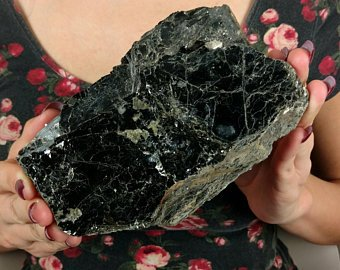

In [ ]:
from IPython.display import Image

print("Biotita")
Image("/content/gdrive/MyDrive/minet/test/biotite/0057.jpg", width = 500, height = 300) #Mostramos una Biotita

Bornita


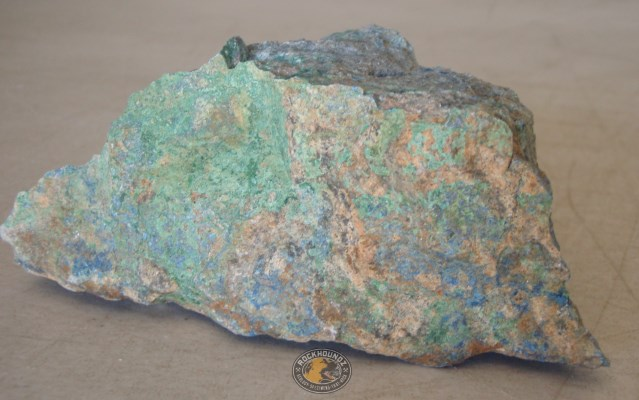

In [ ]:
print("Bornita")
Image("/content/gdrive/MyDrive/minet/test/bornite/0123.jpg", width = 500, height = 300) #Mostramos una Bornita

Crisocola


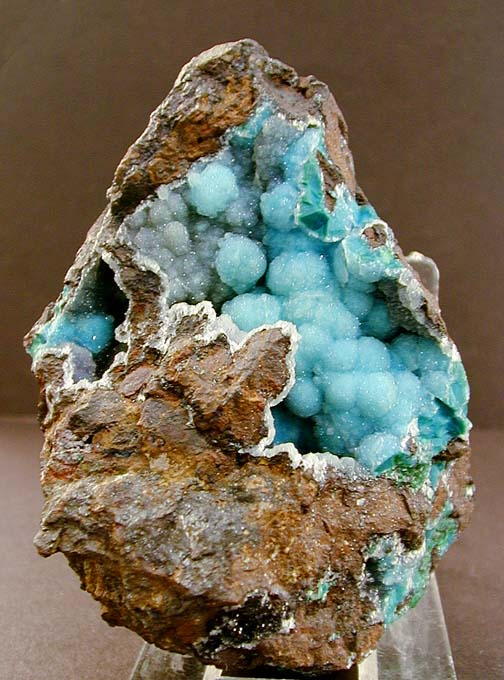

In [ ]:
print("Crisocola")
Image("/content/gdrive/MyDrive/minet/test/chrysocolla/0114.jpg", width = 500, height = 500) #Mostramos una Crisocola

In [ ]:
inputs = keras.Input(shape=(180, 180, 3)) #definimos el tamaño de las entradas para la red

x = layers.Rescaling(1./255)(inputs) #normalizamos el valor de los pixeles

'''
A continuación se desarrola la arquitectura de la red convolucional
'''
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

La arqeuitectura de la red es la siguiente
* 4 capas Conv2D - MaxPooling2D y función de activación ReLu
* 1 capa Conv2D - Flatten función de activación ReLu
* última capa con 3 nodos y función de activación softmax

Usaremos la función de activación **Rectified linear** por su simplicidad en el cálculo. Es conveniente pues tenemos 5 capas ocultas.

In [ ]:
model.summary()     #Se observa la tamaño que va adquiriendo cada capa en la red
                    #además de las parametros generados.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [ ]:
#No cambiar ninguna de las funciones, pues son especificas para una clasificación en tres categorias

model.compile(optimizer="rmsprop", #algoritmo de optimización (Root Mean Square Propagation)
    loss="sparse_categorical_crossentropy", #función de perdida
    metrics=["accuracy"]) #metrica usada

El algoritmo de optimización RMSProp o **Root Mean Square Propagation** es una variante del algoritmo AdaGrad que ajusta automáticamente el learning rate de cada parámetro en vez de tomarlo como un hiperparámetro. Esto permite que la convergencia del algoritmo sea mas rápida que la del SGD.

La función **sparse categorical crossentropy** se utiliza en tareas de clasificación múltiple, esta función compara la distribución de probabilidad obtenida con la distribución de probabilidad esperada. Entre mayor sea el valor de la función, mayor es la diferencia entre ellas. Softmax es la única función de activación recomendada para usarse con sparse categorical crossentropy.

In [ ]:
for data_batch, labels_batch in train_dataset:        #Definimos el tamaño del batch
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [ ]:
callbacks = [                                   #Guarda información en un tensor para hacer predicciones futuras
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(                            #Guarda el historial del entrenamiento para estudiarla luego
    train_dataset,
    epochs=50, #En modelos no preentrenados usamos 50 epocas
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
5/5 [==============================] - 14s 499ms/step - loss: 1.7562 - accuracy: 0.3836 - val_loss: 1.1457 - val_accuracy: 0.3516
Epoch 2/50
5/5 [==============================] - 2s 207ms/step - loss: 1.0102 - accuracy: 0.4340 - val_loss: 1.7323 - val_accuracy: 0.3626
Epoch 3/50
5/5 [==============================] - 2s 213ms/step - loss: 1.2219 - accuracy: 0.4151 - val_loss: 1.0380 - val_accuracy: 0.3516
Epoch 4/50
5/5 [==============================] - 2s 208ms/step - loss: 1.0032 - accuracy: 0.4528 - val_loss: 1.1297 - val_accuracy: 0.3516
Epoch 5/50
5/5 [==============================] - 2s 206ms/step - loss: 1.1033 - accuracy: 0.4465 - val_loss: 1.0807 - val_accuracy: 0.3516
Epoch 6/50
5/5 [==============================] - 2s 226ms/step - loss: 0.9905 - accuracy: 0.4214 - val_loss: 1.0826 - val_accuracy: 0.3736
Epoch 7/50
5/5 [==============================] - 2s 217ms/step - loss: 0.9787 - accuracy: 0.5597 - val_loss: 0.8913 - val_accuracy: 0.5495
Epoch 8/50
5/5 [===

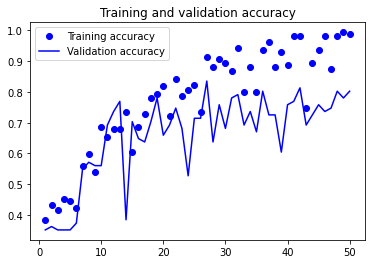

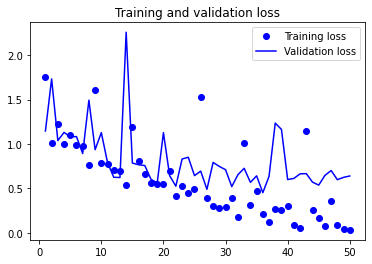

In [ ]:
'''
En esta celda se grafica el comportamiento para validación y entrenmamiento
de la precisión y la función de perdida
'''

import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")      #Se evalua el modelo con los datos tipo test y se obtiene la presición resultante
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

5/5 [==============================] - 1s 105ms/step - loss: 0.3997 - accuracy: 0.8311
Test accuracy: 0.831


Observamos una separación entre la precisión y la pérdida a partir de la época 30 aproximadamente.

Recordemos que tenemos una cantidad reducidad de imágenes en el dataset por lo que usar data agumentartion será fundamental para tratar el overfitting de nuestra CNN, además agregaremos dropout de $0.5$ en el siguiente modelo para reducir aún mas el overfitting.

### Data augmentation y dropout 0.5

In [ ]:
data_augmentation = keras.Sequential(       #Se crea una función para la data augmentation de las imagenes,
                                            #a través de la rotación, giros y zoom sobre imagenes
    [
        layers.RandomFlip("vertical"),
        layers.RandomRotation(0.25),
        layers.RandomZoom(0.3),
    ]
)

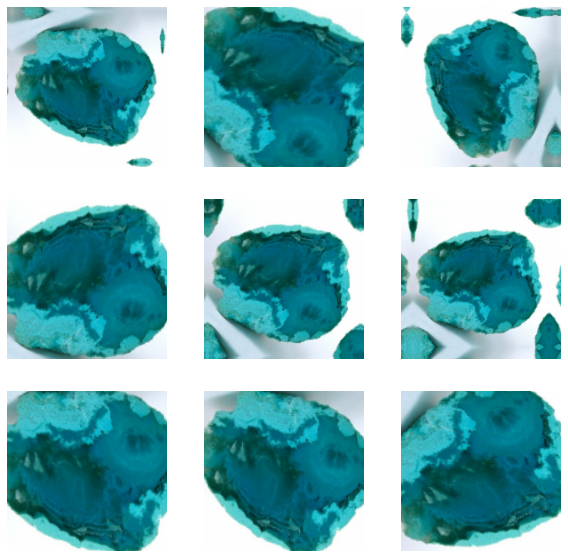

In [ ]:
plt.figure(figsize=(10, 10))                                      #Se aplica la función data_augmentation
                                                                  #a las imagenes y se muestran
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
'''
Se repite la arquitectura ya usada
'''

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x) #Se normaliza
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x) #Se agrega dropout de 0.5
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
'''
Se repiten las funciones ya usadas
'''

model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

In [ ]:
callbacks = [                                                     #Guarda información en un tensor para hacer predicciones futuras
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(                                              #Guarda el historial del entrenamiento para estudiarla luego
    train_dataset,
    epochs=50, #Usar solamente 50 epocas
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
5/5 [==============================] - 14s 505ms/step - loss: 1.1543 - accuracy: 0.4654 - val_loss: 1.0650 - val_accuracy: 0.3626
Epoch 2/50
5/5 [==============================] - 2s 225ms/step - loss: 1.0479 - accuracy: 0.4654 - val_loss: 4.7226 - val_accuracy: 0.3626
Epoch 3/50
5/5 [==============================] - 2s 240ms/step - loss: 1.6073 - accuracy: 0.3836 - val_loss: 1.0435 - val_accuracy: 0.4725
Epoch 4/50
5/5 [==============================] - 2s 215ms/step - loss: 0.9253 - accuracy: 0.5597 - val_loss: 1.1328 - val_accuracy: 0.3626
Epoch 5/50
5/5 [==============================] - 2s 234ms/step - loss: 0.8597 - accuracy: 0.5157 - val_loss: 0.7716 - val_accuracy: 0.6593
Epoch 6/50
5/5 [==============================] - 2s 226ms/step - loss: 1.1226 - accuracy: 0.5346 - val_loss: 0.9993 - val_accuracy: 0.5055
Epoch 7/50
5/5 [==============================] - 2s 240ms/step - loss: 0.8688 - accuracy: 0.6541 - val_loss: 0.6845 - val_accuracy: 0.6374
Epoch 8/50
5/5 [===

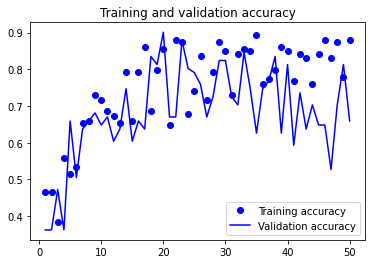

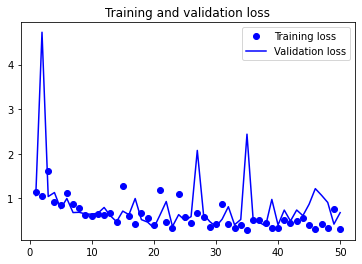

In [ ]:
'''
En esta celda se grafica el comportamiento para validación y entrenmamiento
de la precisión y la función de perdida
'''

import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
'''
En esta celda se grafica el comportamiento para validación y entrenmamiento
de la precisión y la función de perdida
'''

test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

5/5 [==============================] - 1s 98ms/step - loss: 0.3156 - accuracy: 0.8919
Test accuracy: 0.892


La precisión es bastante buena, podría mejorar un poco al usar early stopping en la red.

En resumen hasta este punto: **con data augmentation y dropout** la presición es de **0.892** y sin data augmentation y dropout la presición es **0.831**

## Modelo preentrenado

Utilizaremos el modelo VGG16 disponible en Keras.

In [ ]:
conv_base = keras.applications.vgg16.VGG16( #Se define el modelo preentrenado VGG16, sin entrenar pesos previos
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [ ]:
conv_base.summary() #Se observa la arquitectura del modelo

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

El modelo VGG16 cuenta con 13 capas de convolución y 3 capas densas.

La red VGG16 fue entrenada para resolver el problema de clasificación de 1000 clases en ImageNet, debe en sus pesos codificar información para extraer rasgos de distintas clases de animales representadas en las mas de 1.4 millones de fotografías de ImageNet. Entre esas clases hay muy distintas variedades de animales, en muy distintos entornos. Por ello, VGG16 es una muy buena candidata para resolver este problema de clasificación de 3 clases.

In [ ]:
'''
En este bloque de codigo se preparan las imagenes para poder ser utilizadas por el VGG16
'''

import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [ ]:
train_features.shape

(159, 5, 5, 512)

In [ ]:
'''
En este bloque de código, se implementan las entradas y salidas de la red, las
funciones de perdida, el optimizador y la metrica. Además de definar los callbacks
y el objeto history. Con el fin de comprobar que la red VGG16 esta bien implementada
'''


inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20, #Usar 100 epocas para los modelos preentrenados
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
5/5 [==============================] - 1s 54ms/step - loss: 153.0110 - accuracy: 0.4780 - val_loss: 101.1311 - val_accuracy: 0.4725
Epoch 2/20
5/5 [==============================] - 0s 25ms/step - loss: 10.1875 - accuracy: 0.8868 - val_loss: 55.8091 - val_accuracy: 0.6923
Epoch 3/20
5/5 [==============================] - 0s 24ms/step - loss: 5.7864 - accuracy: 0.9623 - val_loss: 37.7102 - val_accuracy: 0.7143
Epoch 4/20
5/5 [==============================] - 0s 25ms/step - loss: 1.4371 - accuracy: 0.9748 - val_loss: 35.0494 - val_accuracy: 0.7033
Epoch 5/20
5/5 [==============================] - 0s 11ms/step - loss: 0.6224 - accuracy: 0.9874 - val_loss: 39.9568 - val_accuracy: 0.7143
Epoch 6/20
5/5 [==============================] - 0s 27ms/step - loss: 0.1691 - accuracy: 0.9937 - val_loss: 33.9488 - val_accuracy: 0.7473
Epoch 7/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 33.9490 - val_accuracy: 0.7473
Epoch 8/20
5

Los resultados este entrenamiento de 20 épocas no se tomarán en cuenta hasta agragar data augmentation al modelo. Aquí simplemente nos aseguramos de que el modelo VGG16 esté funcionando.

In [ ]:
'''
test_model = keras.models.load_model(
    "feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")
'''

'\ntest_model = keras.models.load_model(\n    "feature_extraction.keras")\ntest_loss, test_acc = test_model.evaluate(test_dataset)\nprint(f"Test accuracy: {test_acc:.3f}")\n'

VGG16 con **data augmentation**

In [ ]:
conv_base  = keras.applications.vgg16.VGG16( #Se vuelve a declarar el modelo VGG16, sin modificar pesos
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.trainable = True                            #Se indican los tensores que se reentrenaran en el modelo
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False                           #Se indica el número de tensores que se reentranaron
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [ ]:
data_augmentation = keras.Sequential(         #Define el función para el data augmentation
    [
        layers.RandomFlip("vertical"),
        layers.RandomRotation(0.25),
        layers.RandomZoom(0.3),
    ]
)

'''
Ahora se crean las arquitecturas para los datos de entrada de la red,
los nodos de salida, y las funciónes de perdida, metrica y optimización.
'''

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x) #Declaramos un dropout
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [                                   #Se guardan datos en forma tensorial, para usarlos despues
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(                            #Se crea un objeto de historial que guarde los datos del
                                                #performance logrado y que pueda ser usado despues
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
5/5 [==============================] - 3s 405ms/step - loss: 113.0378 - accuracy: 0.4906 - val_loss: 40.4041 - val_accuracy: 0.6923
Epoch 2/100
5/5 [==============================] - 2s 310ms/step - loss: 29.2086 - accuracy: 0.7170 - val_loss: 62.9759 - val_accuracy: 0.6484
Epoch 3/100
5/5 [==============================] - 2s 362ms/step - loss: 16.3277 - accuracy: 0.8679 - val_loss: 17.9535 - val_accuracy: 0.7802
Epoch 4/100
5/5 [==============================] - 2s 310ms/step - loss: 11.1301 - accuracy: 0.8616 - val_loss: 23.8779 - val_accuracy: 0.7692
Epoch 5/100
5/5 [==============================] - 2s 308ms/step - loss: 10.9768 - accuracy: 0.8428 - val_loss: 24.6624 - val_accuracy: 0.7363
Epoch 6/100
5/5 [==============================] - 2s 310ms/step - loss: 5.2510 - accuracy: 0.9057 - val_loss: 47.6638 - val_accuracy: 0.6923
Epoch 7/100
5/5 [==============================] - 2s 312ms/step - loss: 8.6535 - accuracy: 0.8679 - val_loss: 24.1281 - val_accuracy: 0.8022


KeyboardInterrupt: ignored

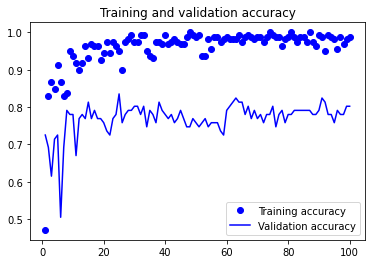

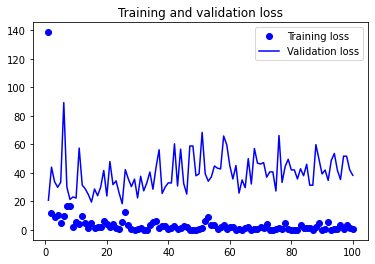

In [ ]:
'''
En esta celda se grafica el comportamiento para validación y entrenmamiento
de la precisión y la función de perdida
'''

import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

5/5 [==============================] - 1s 93ms/step - loss: 32.5925 - accuracy: 0.8446
Test accuracy: 0.845


La presición también es buena pero podemos ver en la gráfica que hay una separación considerable en el desempeño del modelo con el conjunto de train y validation, veamos si con fine tunning se corrige el problema.

## Fine tuning

In [ ]:
conv_base.trainable = True              #Define que bloques entrenen sus pesos y cuales no
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",       #Se compila con las funciones ya mencionadas
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), #Se usa un learning_rate muy pequeño, pues el modelo es preentrenado
              metrics=["accuracy"])

callbacks = [                               #Crea tensores para guardar datos
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(                        #Crea el historial para graficar y observar el entrenamiento de la red
    train_dataset,
    epochs=100, #Usar solamente 50 epocas
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
5/5 [==============================] - 7s 732ms/step - loss: 14.7846 - accuracy: 0.3333 - val_loss: 12.1709 - val_accuracy: 0.4945
Epoch 2/100
5/5 [==============================] - 4s 659ms/step - loss: 12.6869 - accuracy: 0.4025 - val_loss: 8.8921 - val_accuracy: 0.4725
Epoch 3/100
5/5 [==============================] - 4s 643ms/step - loss: 8.1484 - accuracy: 0.4969 - val_loss: 7.6869 - val_accuracy: 0.4945
Epoch 4/100
5/5 [==============================] - 4s 638ms/step - loss: 6.9532 - accuracy: 0.5409 - val_loss: 7.2357 - val_accuracy: 0.5275
Epoch 5/100
5/5 [==============================] - 4s 635ms/step - loss: 6.5786 - accuracy: 0.5535 - val_loss: 6.7292 - val_accuracy: 0.5385
Epoch 6/100
5/5 [==============================] - 4s 639ms/step - loss: 7.5452 - accuracy: 0.5220 - val_loss: 6.4780 - val_accuracy: 0.5385
Epoch 7/100
5/5 [==============================] - 4s 635ms/step - loss: 5.7999 - accuracy: 0.5597 - val_loss: 6.0611 - val_accuracy: 0.5275
Epoch 8/10

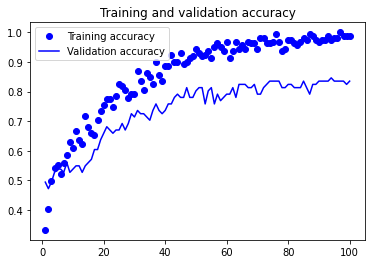

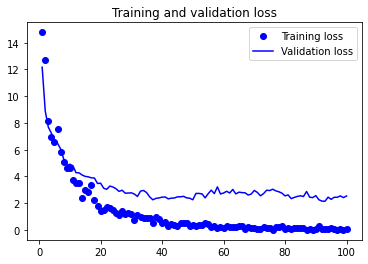

In [ ]:
'''
En esta celda se grafica el comportamiento para validación y entrenmamiento
de la precisión y la función de perdida
'''

import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("fine_tuning.keras") #Evalúa el performance de la red con fine tuning
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

5/5 [==============================] - 2s 186ms/step - loss: 0.5826 - accuracy: 0.9054
Test accuracy: 0.905
